In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [2]:
from nltk import ngrams
from nltk.tokenize import word_tokenize
import re

In [3]:
# loading the data
train_data = pd.read_csv('hi-train.csv', names=['label', 'text'])
test_data = pd.read_csv('hi-test.csv', names=['label', 'text'])
valid_data = pd.read_csv('hi-valid.csv', names=['label', 'text'])
hindi_stopwords = pd.read_csv('stopwords.txt', delimiter ='\t', names=['stopwords'])

In [4]:
hindi_stopwords

,stopwords
0,मैं
1,मुझको
2,मेरा
3,अपने आप को
4,हमने
...,...
259,मे
260,एस
261,उन
262,सो


In [5]:
data = pd.concat([train_data, valid_data])

In [6]:
train_data.head()

,label,text
0,neutral,"निर्माता :\nशीतल विनोद तलवार, मधु‍ मैंटेना\n\n..."
1,positive,’उड़ान’ से विक्रमादित्य\nमोटवाने\nने अच्छे सिन...
2,neutral,फिल्म में गानों के दृश्य में अनुष्का को माइक क...
3,neutral,फांसी चढ़ने से पहले वह पाकिस्तान के सदर से खास...
4,positive,राज कुमार हिरानी ने इस मूवी में भी अपने डायरेक...


In [7]:
test_data.head()

,label,text
0,negative,काव्या अपनी खुन्नस और जिद में सिद्धार्थ को तबा...
1,negative,"निर्माता :\nफरहान अख्तर, रितेश सिधवानी\n\nनिर्..."
2,positive,असमर्पित रिश्ते में यकीन रखने वाले दोनों मौज-म...
3,neutral,"बेवकूफियां को हबीब फैज़ल ने लिखा है, जिनका नाम..."
4,neutral,तब वह मोटी थी और जेरी ने उस पर ध्यान नहीं दिय...


In [8]:
train_data.isnull().sum()

label    0
text     0
dtype: int64

In [9]:
test_data.isnull().sum()

label    0
text     0
dtype: int64

In [10]:
hindi_stopwords.isnull().sum()

stopwords    0
dtype: int64

In [11]:
train_data['label'].value_counts()

label
positive    1042
negative     741
neutral      697
Name: count, dtype: int64

In [12]:
test_data['label'].value_counts()

label
positive    122
negative     98
neutral      90
Name: count, dtype: int64

In [13]:
# Normalizing the texts
import re

def normalize_text(text):
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    return text

In [14]:
# Removing the Stopwords

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in hindi_stopwords]
    return " ".join(filtered_words)

In [15]:
#Stemming
from indicnlp import common
from indicnlp.tokenize import indic_tokenize
from indicnlp.morph import unsupervised_morph

common.set_resources_path('C:/Users/ASUS/AppData/Roaming/Python/Python311/site-packages/indicnlp')

stemmer = unsupervised_morph.UnsupervisedMorphAnalyzer('hi')

def stem_text(text):
    tokens = indic_tokenize.trivial_tokenize(text)
    
    stemmed_tokens = []
    for token in tokens:
        try:
            root = stemmer.morph_analyze_document(token)['root']
        except KeyError:
            root = token
        stemmed_tokens.append(root)

    return ' '.join(stemmed_tokens)

In [16]:
# tokenization

from indicnlp.tokenize import indic_tokenize

def tokenize_text(text):
    tokens = indic_tokenize.trivial_tokenize(text)
    return tokens

In [17]:
# Load dataset
df = pd.DataFrame(data)

# Preprocessing function
def preprocess_text(text):
    # Step 1: Normalize
    text = normalize_text(text)
    
    # Step 2: Remove stopwords
    text = remove_stopwords(text)
    
    # Step 3: Stemming
    text = stem_text(text)
    
    # Step 4: Tokenize 
    tokens = tokenize_text(text)
    
    return ' '.join(tokens)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2790 entries, 0 to 309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2790 non-null   object
 1   text    2790 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [33]:
print(type(df['text'].iloc[0]))  # Should return str or list

<class 'str'>


In [19]:
from indicnlp.tokenize import indic_tokenize
from indicnlp.morph import unsupervised_morph
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

# Initialize the unsupervised stemmer (ensure the model path is correct)
stemmer = unsupervised_morph.UnsupervisedMorphAnalyzer('hi')

# Function for text cleaning and preprocessing
def preprocess_text(text):
    # Step 1: Normalize text
    text = normalize_text(text)
    
    # Step 2: Remove unwanted characters (like numbers, punctuation, etc.)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers

    # Step 3: Tokenize the text
    tokens = tokenize_text(text)

    # Step 4: Remove stopwords (for Hindi)
    text = remove_stopwords(text)
    
    # Step 5: Lemmatize/stem each token
    stemmed_tokens = []
    for token in tokens:
        try:
            root = stemmer.morph_analyze_word(token)[0]  # Fix for accessing correct output
            stemmed_tokens.append(root)
        except Exception as e:
            stemmed_tokens.append(token)  # Fallback to original token if stemming fails

    # Join tokens back into a string
    return ' '.join(stemmed_tokens)

In [20]:
# Apply the preprocessing function to the 'text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Check results
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  निर्माता :\nशीतल विनोद तलवार, मधु‍ मैंटेना\n\n...   
1  ’उड़ान’ से विक्रमादित्य\nमोटवाने\nने अच्छे सिन...   
2  फिल्म में गानों के दृश्य में अनुष्का को माइक क...   
3  फांसी चढ़ने से पहले वह पाकिस्तान के सदर से खास...   
4  राज कुमार हिरानी ने इस मूवी में भी अपने डायरेक...   

                                        cleaned_text  
0  नरमत \nशतल वनद तलवर मध मटन\n\nनरदशक \nरमगपल वर...  
1  उडन स वकरमदतय\nमटवन\nन अचछ सनम क उममद जगई थ और...  
2  फलम म गन क दशय म अनषक क मइक क समन लकदक कसटयम म...  
3  फस चढन स पहल वह पकसतन क सदर स खस इजजत लकर मडय ...  
4  रज कमर हरन न इस मव म भ अपन डयरकशन क जलव दख दय ...  


In [21]:
def get_ngrams(text, n=2):
    words = word_tokenize(text)
    return [' '.join(ng) for ng in ngrams(words, n)]

In [22]:
# Create bigrams and trigrams
df['bigrams'] = df['cleaned_text'].apply(lambda x: get_ngrams(x, n=2))
df['trigrams'] = df['cleaned_text'].apply(lambda x: get_ngrams(x, n=3))

In [24]:
df['combined_text'] = df['cleaned_text'] + ' ' + df['bigrams'].apply(lambda x: ' '.join(x)) + ' ' + df['trigrams'].apply(lambda x: ' '.join(x))

In [25]:
# Define features and labels
X = df['combined_text']
y = df['label']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [28]:
from sklearn.svm import SVC

In [29]:
model = SVC()

# Train the model
model.fit(X_train_tfidf, y_train)

SVC()

In [39]:
# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.553763440860215
              precision    recall  f1-score   support

    negative       0.65      0.41      0.50       174
     neutral       0.63      0.23      0.34       156
    positive       0.52      0.89      0.65       228

    accuracy                           0.55       558
   macro avg       0.60      0.51      0.50       558
weighted avg       0.59      0.55      0.52       558



In [36]:
rf_model = RandomForestClassifier()

In [37]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


In [38]:
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END max_depth=None, m

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [40]:
best_model = grid_search.best_estimator_

In [41]:
y_pred = best_model.predict(X_test_tfidf)

# Evaluation
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5752688172043011
              precision    recall  f1-score   support

    negative       0.62      0.49      0.55       174
     neutral       0.64      0.31      0.42       156
    positive       0.54      0.82      0.65       228

    accuracy                           0.58       558
   macro avg       0.60      0.54      0.54       558
weighted avg       0.60      0.58      0.55       558



In [42]:
import matplotlib.pyplot as plt

In [43]:
# Visualization of data

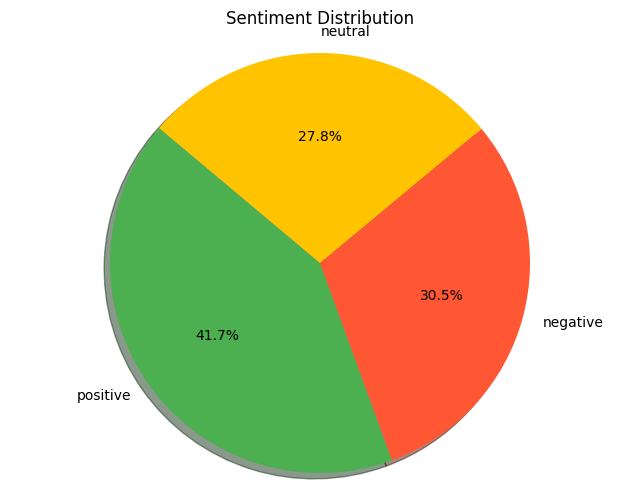

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

sentiment_counts = data['label'].value_counts()

labels = list(sentiment_counts.index)
sizes = list(sentiment_counts.values)

colors = ['#4CAF50', '#FF5733', '#FFC300']


plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.axis('equal')

plt.title('Sentiment Distribution')

plt.show()

In [47]:
# Saving the model

joblib.dump(best_model, 'sentiment_model.pkl')
print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
